In [49]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from os import listdir, makedirs
import pickle

In [50]:
# Data location
PROJECT_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp_6'
DATA_PATH = f'{PROJECT_PATH}/data'
RESULTS_PATH = f'{PROJECT_PATH}/results'
TRANSITION_RESULTS_DIR = 'transition-influence'
TRANSITION_RESULTS_RESIDUALS_DIR = 'transition-influence-residuals'
FIG_PATH = f'{PROJECT_PATH}/figs'

# Model info
MODELS = ['ss', 'ss-sampler', 'ff']
N_PARAM_BINS = 5

# Aesthetics
MODEL_COLORS = {
    'ss': '#9cd8ff',
    'ss-sampler': '#3DB2FF',
    'ff': '#FF2442'
}
TRANSITION_INFLUENCE_COLORS = {
    'incidental': '#F52342',
    'true': '#FFBC42'
}

In [51]:
# Mkae figure path if it does not exist
makedirs(FIG_PATH, exist_ok=True)

# Functions

## Helper Functions

In [52]:
def load_data_from_dir(dpath):
    """
    Load data from a directory into a single pandas DataFrame
    
    Arguments
    ---------
    dpath : str
        path to data directory
        
    Returns
    -------
    data : pd.DataFrame
        phase data
    """
    data = []
    for f in listdir(dpath):
        if f.startswith('.'):
            continue
        data.append(pd.read_csv(f'{dpath}/{f}'))
    data = pd.concat(data)
    return data

def get_frequent_targets(df):
    """
    Get frequent targets from a DataFrame

    Arguments
    ---------
    df : pd.DataFrame
        Choice phase data
    
    Returns
    -------
    None
    """
    df['freq'] = 0
    idx = (
        (df['target'] == '[1 4 0 0]') |
        (df['target'] == '[4 1 0 0]') |
        (df['target'] == '[0 0 1 4]') |
        (df['target'] == '[0 0 4 1]') 
    )
    df.loc[idx, 'freq'] = 1

def convert_states_to_labels(states):
    """
    Convert array of states to string labels

    Arguments
    ---------
    states : np.ndarray
        Array represent states by their features

    Returns
    -------
    labels : list
        state labels
    """
    labels = [''.join(label) for label in states.astype(str)]
    return labels

def standardize_reps_order(reps):
    """
    Standardize the order of representations

    Arguments
    ---------
    reps : dict
        representation dictionary

    Returns
    -------
    reps : dict
        standardized representation dictionary
    """
    
    # Get indices for standardized ordering
    idx_sorted_S = np.lexsort(reps['S'].T[::-1])
    idx_sorted_F = np.lexsort(reps['F_raw'].T[::-1])
    S = reps['S'][idx_sorted_S]
    F_raw = reps['F_raw'][idx_sorted_F]

    # Re-order rows by whether starts are conjunctive or not
    if reps['agent_info']['conjunctive_starts']:
        M = reps['M'][idx_sorted_S]
        bias = reps['bias'][idx_sorted_S]
        row_labels = convert_states_to_labels(S)
    else:
        M = reps['M'][idx_sorted_F]
        bias = reps['bias'][idx_sorted_F]
        row_labels = convert_states_to_labels(F_raw)

    # Re-order columns by whether successors are conjunctive or not
    if reps['agent_info']['conjunctive_successors']:
        M = M.T[idx_sorted_S].T
        bias = bias.T[idx_sorted_S].T
        col_labels = convert_states_to_labels(S)
    else:
        M = M.T[idx_sorted_F].T
        bias = bias.T[idx_sorted_F].T
        col_labels = convert_states_to_labels(F_raw)

    # Assign re-ordered representations
    reps['S'] = S
    reps['F_raw'] = F_raw
    reps['M'] = M
    reps['bias'] = bias
    reps['row_labels'] = row_labels
    reps['col_labels'] = col_labels

    return reps

def set_axis_ratio(ax, ratio=1):
    """
    Make axis aspect ratio square
    
    Arguments
    ---------
    ax : matplotlib.Axes
        matplotlib axis to transform
    ratio : int or float
        ratio of y- to x-axis
        
    Returns
    -------
    None
    """
    ax.set_aspect(ratio/ax.get_data_ratio(), adjustable='box')

def round_interval_labels(interval_series, n):
    """
    Round interval labels to n decimal places

    Arguments
    ---------
    interval_series : pd.Series
        series of pandas Interval objects
    
    Returns
    -------
    interval_series : pd.Series
        series of pandas Interval objects with rounded labels
    """
    return interval_series.apply(
        lambda x: pd.Interval(
            round(x.left, n),
            round(x.right, n)
        )
    )

def bin_params(params, n_bins, method=pd.cut):
    """
    Bin parameters into n_bins

    Arguments
    ---------
    params : np.ndarray
        parameter values
    n_bins : int
        number of bins
    
    Returns
    -------
    params_binned : np.ndarray
        binned parameter values
    """
    params_binned = method(params, n_bins)
    params_binned = round_interval_labels(params_binned, 2)
    return params_binned

## Plot Functions

In [53]:
def plot_training_curve(
        df,
        y,
        grouping_var,
        palette = 'rocket',
        title = None,
        legend_title = None):
    """
    Plot training curve

    Arguments
    ---------
    df : pd.DataFrame
        training data
    y : str
        variable to plot on y-axis ('reward' or 'p')
    grouping_var : str
        variable to group by
    palette : list
        color palette
    title : str
        title for plot
    legend_title : str
        title for legend
    
    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(6, 3))
    blocks = df['block'].unique()
    if len(blocks) > 1:
        ax.axvline(np.max(df['trial'])/len(blocks), color='black')
    for block in blocks:
        idx = df['block'] == block
        sns.lineplot(
            data = df.loc[idx],
            x = 'trial',
            y = y,
            hue = grouping_var,
            palette = palette,
            ci = None
        )
    n_labels = len(df[grouping_var].unique())
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.legend(
        handles[-n_labels:],
        labels[-n_labels:],
        title = legend_title,
        loc = (1.05, .45)
    )
    ax.set_xlabel('Trial')
    if y == 'reward':
        max_reward = np.max(df['reward'])
        ax.axhline(max_reward/2, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Reward')
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.axhline(.25, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('P(Choice)')
        ax.set_ylim(0, 1)
    elif y == 'resid':
        ax.axhline(.72, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Residual')
        ax.set_ylim(0, 1)
    ax.set_title(title, loc='left')

def plot_param_interaction(
        df,
        continous_param,
        binned_param,
        y,
        title = None,
        legend_title = None,
        xlabel = None,
        ylabel = None,
        palette = 'rocket'
):
    
    # Get average reward by alpha and segmentation bin
    plot_df = df[['id', continous_param, binned_param, y]]
    plot_df = plot_df.groupby(['id', continous_param, binned_param])
    plot_df = plot_df.mean().reset_index()

    # Y-intercept of chance line
    if y == 'reward':
        max_reward = np.max(df['reward'])
        chance = max_reward/2
    elif y == 'p':
        chance = .25
    elif y == 'coef':
        chance = 0
    
    # Plot
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.axhline(chance, color='black', linestyle='--', zorder=0)
    n_bins = len(plot_df[binned_param].unique())
    for i, param_bin in enumerate(plot_df[binned_param].unique()):
        idx = plot_df[binned_param] == param_bin
        sns.regplot(
            data = plot_df.loc[idx],
            x = continous_param,
            y = y,
            scatter = False,
            color = sns.color_palette(palette, n_bins)[i],
            label = param_bin
        )
    ax.legend(title=legend_title, loc=(1.05, .45))
    if y == 'reward':
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.set_ylim(0, 1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, loc='left')
    set_axis_ratio(ax)

# Load Data

## Training

In [54]:
# Load training data
training_df = []
for model in MODELS:
    training_df.append(load_data_from_dir(f'{DATA_PATH}/{model}/training'))
training_df = pd.concat(training_df)
training_df = training_df.reset_index(drop=True)

# Label blocks
n_training_trials = np.max(training_df['trial'])
training_df['block'] = (training_df['trial'] > n_training_trials/2) + 1

# Label frequent targets
get_frequent_targets(training_df)

training_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,initial_bias_weight,conjunctive_starts,...,options_comb,target,options,composition,successor,p,reward,correct,block,freq
0,1572,ss,0.806781,0,1.413834,1.413834,1.0,0.686719,0.181527,True,...,[1 1 0 0],[1 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 3 0 0],[4 4 0 0],0.250000,0,0,1,0
1,1572,ss,0.806781,0,1.413834,1.413834,1.0,0.686719,0.181527,True,...,[1 1 0 0],[1 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 3 0 0],[4 4 0 0],0.250000,0,0,1,0
2,1572,ss,0.806781,0,1.413834,1.413834,1.0,0.686719,0.181527,True,...,[1 1 0 0],[1 4 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 3 0 0],[1 4 0 0],0.265103,2,1,1,1
3,1572,ss,0.806781,0,1.413834,1.413834,1.0,0.686719,0.181527,True,...,[1 1 0 0],[4 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 2 0 0],[4 1 0 0],0.260181,2,1,1,1
4,1572,ss,0.806781,0,1.413834,1.413834,1.0,0.686719,0.181527,True,...,[1 1 0 0],[4 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 2 0 0],[1 1 0 0],0.287306,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439995,385,ff,0.250890,0,0.417067,0.417067,1.0,0.629796,0.663915,False,...,[0 0 1 1],[0 0 1 4],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 2 3],[0 0 1 4],0.999833,2,1,2,1
1439996,385,ff,0.250890,0,0.417067,0.417067,1.0,0.629796,0.663915,False,...,[0 0 1 1],[0 0 4 1],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 2],[0 0 4 1],0.999973,2,1,2,1
1439997,385,ff,0.250890,0,0.417067,0.417067,1.0,0.629796,0.663915,False,...,[0 0 1 1],[0 0 4 1],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 2],[0 0 4 1],0.999982,2,1,2,1
1439998,385,ff,0.250890,0,0.417067,0.417067,1.0,0.629796,0.663915,False,...,[0 0 1 1],[0 0 1 4],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 2 3],[0 0 1 4],0.999906,2,1,2,1


## Test

In [55]:
test_df = []
for model in MODELS:
    test_df.append(load_data_from_dir(f'{DATA_PATH}/{model}/test'))
test_df = pd.concat(test_df)
test_df = test_df.reset_index(drop=True)
test_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,initial_bias_weight,conjunctive_starts,...,trial,target_comb,options_comb,target,options,composition,successor,p,reward,correct
0,1119,ss,0.480318,0,0.431056,0.431056,1.0,0.231027,0.191014,True,...,1,[0 0 1 1],[1 1 0 0],[0 0 1 1],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 2 0 0],[4 1 0 0],0.250000,0,0
1,1119,ss,0.480318,0,0.431056,0.431056,1.0,0.231027,0.191014,True,...,2,[0 0 1 1],[1 1 0 0],[0 0 1 4],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 3 0 0],[1 4 0 0],0.250000,0,0
2,1119,ss,0.480318,0,0.431056,0.431056,1.0,0.231027,0.191014,True,...,3,[0 0 1 1],[1 1 0 0],[0 0 4 1],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 2 0 0],[1 1 0 0],0.250000,0,0
3,1119,ss,0.480318,0,0.431056,0.431056,1.0,0.231027,0.191014,True,...,4,[0 0 1 1],[1 1 0 0],[0 0 4 4],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 2 0 0],[4 1 0 0],0.250000,0,0
4,1119,ss,0.480318,0,0.431056,0.431056,1.0,0.231027,0.191014,True,...,5,[0 1 0 1],[1 1 0 0],[0 1 0 1],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 2 0 0],[4 1 0 0],0.945548,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431995,149,ff,0.668935,0,1.022775,1.022775,1.0,0.641688,0.615567,False,...,140,[1 0 1 0],[0 0 1 1],[4 0 4 0],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 3],[0 0 4 4],0.999539,1,0
431996,149,ff,0.668935,0,1.022775,1.022775,1.0,0.641688,0.615567,False,...,141,[1 1 0 0],[0 0 1 1],[1 1 0 0],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 2 3],[0 0 1 4],0.250000,0,0
431997,149,ff,0.668935,0,1.022775,1.022775,1.0,0.641688,0.615567,False,...,142,[1 1 0 0],[0 0 1 1],[1 4 0 0],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 3],[0 0 4 4],0.250000,0,0
431998,149,ff,0.668935,0,1.022775,1.022775,1.0,0.641688,0.615567,False,...,143,[1 1 0 0],[0 0 1 1],[4 1 0 0],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 2],[0 0 4 1],0.250000,0,0


## Representations

In [57]:
representations = {}
for model in MODELS:
    for fname in listdir(f'{DATA_PATH}/{model}/representations'):
        if fname.startswith('.'):
            continue
        agent_id = int(fname.split('_')[1].replace('.pkl', ''))
        with open(f'{DATA_PATH}/{model}/representations/{fname}', 'rb') as f:
            representations[agent_id] = standardize_reps_order(pickle.load(f))

## Subject Information 

In [56]:
subj_df = test_df[[
    'id',
    'model_label',
    'alpha',
    'beta',
    'segmentation',
    'initial_bias_weight'
]]
subj_df = subj_df.drop_duplicates()
subj_df = subj_df.reset_index(drop=True)
subj_df

,id,model_label,alpha,beta,segmentation,initial_bias_weight
0,1119,ss,0.480318,0.431056,0.231027,0.191014
1,1131,ss,0.218304,0.338266,0.923635,0.277425
2,1657,ss,0.124929,4.839140,0.888347,0.945529
3,1643,ss,0.672219,0.546497,0.045326,0.663433
4,1125,ss,0.652951,47.326931,0.071617,0.622260
...,...,...,...,...,...,...
2995,161,ff,0.971838,0.066965,0.096666,0.135926
2996,607,ff,0.602349,0.050233,0.483570,0.867774
2997,613,ff,0.426899,0.524183,0.483999,0.015455
2998,175,ff,0.541161,0.123912,0.805548,0.730477


## Transition Influence

### Results

In [57]:
trans_influence_df = []
for model in ['ff']:#MODELS:
    this_path = f'{RESULTS_PATH}/{model}/{TRANSITION_RESULTS_DIR}'
    for fname in listdir(this_path):
        if fname.startswith('.'):
            continue
        
        # Get agent ID from file name
        agent_id = int(fname.replace('.pkl', '').split('_')[1])

        # Load trace
        with open(f'{this_path}/{fname}', 'rb') as f:
            trace = pickle.load(f)

        # Extract coefficients
        coefs = az.summary(trace)['mean'].values
        coefs = coefs.reshape(-1, 2)
        
        try:
            # Add to full results set
            coefs_df = pd.DataFrame({
                'id': agent_id,
                'action': [1, 2, 3],
                'incidental': coefs[:, 0],
                'true': coefs[:, 1]
            })
            trans_influence_df.append(coefs_df)

        except:

            print(f'ISSUE WITH AGENT {agent_id} COEFS')

trans_influence_df = pd.concat(trans_influence_df)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Convert to long
trans_influence_df = pd.melt(
    trans_influence_df,
    id_vars = ['id', 'action'],
    value_vars = ['incidental', 'true'],
    var_name = 'transition',
    value_name = 'coef'
)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Add parameter information
trans_influence_df = pd.merge(
    trans_influence_df,
    subj_df,
    on = 'id'
)

trans_influence_df

,id,action,transition,coef,model_label,alpha,beta,segmentation,initial_bias_weight
0,908,1,incidental,2.227,ff,0.476702,0.409433,0.671438,0.064809
1,908,2,incidental,2.573,ff,0.476702,0.409433,0.671438,0.064809
2,908,3,incidental,2.136,ff,0.476702,0.409433,0.671438,0.064809
3,908,1,true,4.149,ff,0.476702,0.409433,0.671438,0.064809
4,908,2,true,4.398,ff,0.476702,0.409433,0.671438,0.064809
...,...,...,...,...,...,...,...,...,...
1915,953,2,incidental,3.168,ff,0.651051,0.370796,0.166433,0.175688
1916,953,3,incidental,2.856,ff,0.651051,0.370796,0.166433,0.175688
1917,953,1,true,4.814,ff,0.651051,0.370796,0.166433,0.175688
1918,953,2,true,4.466,ff,0.651051,0.370796,0.166433,0.175688


### Residuals

In [58]:
# Load all residuals into a single DataFrame
residuals_df = []
for model in ['ff']:#MODELS:
    this_path = f'{RESULTS_PATH}/{model}/{TRANSITION_RESULTS_RESIDUALS_DIR}'
    for fname in listdir(this_path):
        if fname.startswith('.'):
            continue
        residuals_df.append(pd.read_csv(f'{this_path}/{fname}'))
residuals_df = pd.concat(residuals_df, ignore_index=True)

# Select only the residuals for the executed action
idx = np.eye(4, dtype=bool)[residuals_df['action'].values]
resid = np.array(residuals_df)[:, -4:]
residuals_df['resid'] = resid[idx]
residuals_df = residuals_df[['id', 'trial', 'action', 'resid']]

# Add block information
residuals_df = pd.merge(
    residuals_df,
    training_df[['id', 'trial', 'block']],
    on = ['id', 'trial']
)

# Add parameter information
residuals_df = pd.merge(
    residuals_df,
    subj_df,
    on = 'id'
)

residuals_df

,id,trial,action,resid,block,model_label,alpha,beta,segmentation,initial_bias_weight
0,28,1,0,0.753625,1,ff,0.923104,0.035428,0.866583,0.437971
1,28,2,0,0.543750,1,ff,0.923104,0.035428,0.866583,0.437971
2,28,3,0,0.590250,1,ff,0.923104,0.035428,0.866583,0.437971
3,28,4,1,0.848500,1,ff,0.923104,0.035428,0.866583,0.437971
4,28,5,3,0.896250,1,ff,0.923104,0.035428,0.866583,0.437971
...,...,...,...,...,...,...,...,...,...,...
153595,201,476,2,0.005625,2,ff,0.884965,7.129491,0.833529,0.752627
153596,201,477,1,0.014125,2,ff,0.884965,7.129491,0.833529,0.752627
153597,201,478,1,0.001125,2,ff,0.884965,7.129491,0.833529,0.752627
153598,201,479,2,0.002250,2,ff,0.884965,7.129491,0.833529,0.752627


# Training Analysis

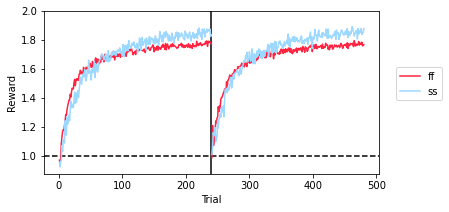

In [9]:
plot_training_curve(
    training_df,
    'reward',
    'model_label',
    palette = MODEL_COLORS
)

## Feature-Based Model

In [10]:
# Get feature-based model data
idx = training_df['model_label'] == 'ff'
ff_training_df = training_df.loc[idx]
ff_training_df = ff_training_df.reset_index(drop=True)

# Check if alpha_decay was simulated
plot_alpha_decay = len(np.unique(ff_training_df['alpha_decay'])) > 1

# Bin parameters
ff_training_df['alpha_bin'] = bin_params(
    ff_training_df['alpha'],
    N_PARAM_BINS
)
if plot_alpha_decay:
    ff_training_df['alpha_decay_bin'] = bin_params(
        ff_training_df['alpha_decay'],
        N_PARAM_BINS,
        method = pd.qcut
    )
ff_training_df['beta_bin'] = bin_params(
    ff_training_df['beta'],
    N_PARAM_BINS,
    method = pd.qcut
)
ff_training_df['segmentation_bin'] = bin_params(
    ff_training_df['segmentation'],
    N_PARAM_BINS
)
ff_training_df['initial_bias_weight_bin'] = bin_params(
    ff_training_df['initial_bias_weight'],
    N_PARAM_BINS
)

### Learning Rate

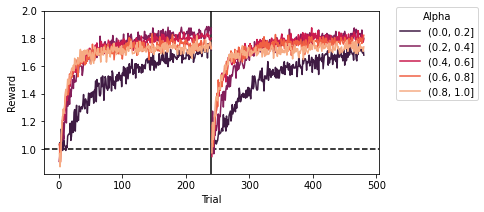

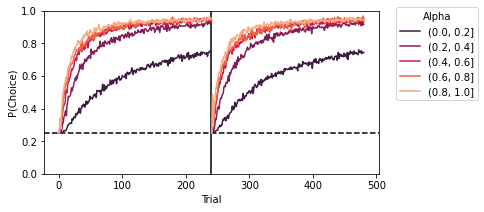

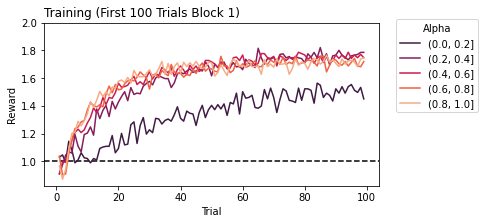

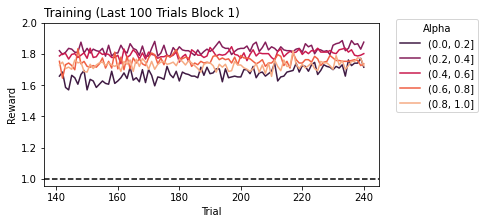

In [11]:
plot_training_curve(
    ff_training_df,
    'reward',
    'alpha_bin',
    palette = 'rocket',
    legend_title = 'Alpha'
)

plot_training_curve(
    ff_training_df,
    'p',
    'alpha_bin',
    palette = 'rocket',
    legend_title = 'Alpha'
)

plot_training_curve(
    ff_training_df.loc[ff_training_df['trial'] < 100],
    'reward',
    'alpha_bin',
    palette = 'rocket',
    legend_title = 'Alpha',
    title = 'Training (First 100 Trials Block 1)'
)

idx = (
    (ff_training_df['trial'] > (n_training_trials/2 - 100)) &
    (ff_training_df['block'] == 1)
)
plot_training_curve(
    ff_training_df.loc[idx],
    'reward',
    'alpha_bin',
    palette = 'rocket',
    legend_title = 'Alpha',
    title = 'Training (Last 100 Trials Block 1)'
)

### Learning Rate Decay

In [108]:
if plot_alpha_decay:
    
    plot_training_curve(
        ff_training_df,
        'reward',
        'alpha_decay_bin',
        palette = 'rocket',
        legend_title = 'Alpha Decay'
    )

    plot_training_curve(
        ff_training_df,
        'p',
        'alpha_decay_bin',
        palette = 'rocket',
        legend_title = 'Alpha Decay'
    )

    plot_training_curve(
        ff_training_df.loc[ff_training_df['trial'] < 100],
        'reward',
        'alpha_decay_bin',
        palette = 'rocket',
        legend_title = 'Alpha Decay',
        title = 'Training (First 100 Trials Block 1)'
    )

    idx = (
        (ff_training_df['trial'] > (n_training_trials/2 - 100)) &
        (ff_training_df['block'] == 1)
    )
    plot_training_curve(
        ff_training_df.loc[idx],
        'reward',
        'alpha_bin',
        palette = 'rocket',
        legend_title = 'Alpha Decay',
        title = 'Training (Last 100 Trials Block 1)'
    )

    idx = ff_training_df['alpha_decay'] < .2
    plot_training_curve(
        ff_training_df.loc[idx],
        'reward',
        'alpha_bin',
        palette = 'rocket',
        legend_title = 'Alpha',
        title = 'Training (Alpha Decay < .2)'
    )

    idx = ff_training_df['alpha_decay'] > .8
    plot_training_curve(
        ff_training_df.loc[idx],
        'reward',
        'alpha_bin',
        palette = 'rocket',
        legend_title = 'Alpha',
        title = 'Training (Alpha Decay > .8)'
    )

    plot_param_interaction(
        ff_training_df.loc[ff_training_df['block'] == 1],
        'alpha',
        'alpha_decay_bin',
        'reward',
        title = 'Training (Block 1)',
        legend_title = 'Alpha Decay',
        xlabel = 'Alpha',
        ylabel = 'Reward',
        palette = 'rocket'
    )

    plot_param_interaction(
        ff_training_df.loc[ff_training_df['block'] == 2],
        'alpha',
        'alpha_decay_bin',
        'reward',
        title = 'Training (Block 2)',
        legend_title = 'Alpha Decay',
        xlabel = 'Alpha',
        ylabel = 'Reward',
        palette = 'rocket'
    )

    plot_param_interaction(
        ff_training_df,
        'alpha',
        'alpha_decay_bin',
        'p',
        title = 'Training',
        legend_title = 'Alpha Decay',
        xlabel = 'Alpha',
        ylabel = 'P(Choice)',
        palette = 'rocket'
    )

### Inverse Temperature

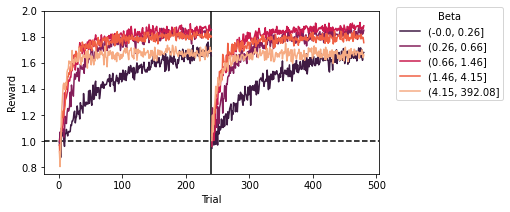

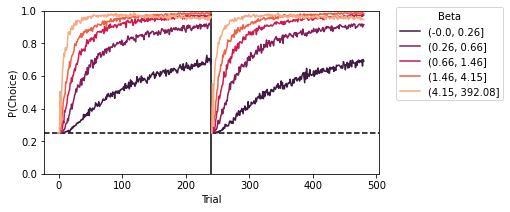

In [12]:
plot_training_curve(
    ff_training_df,
    'reward',
    'beta_bin',
    palette = 'rocket',
    legend_title = 'Beta'
)

plot_training_curve(
    ff_training_df,
    'p',
    'beta_bin',
    palette = 'rocket',
    legend_title = 'Beta'
)

### Segmentation

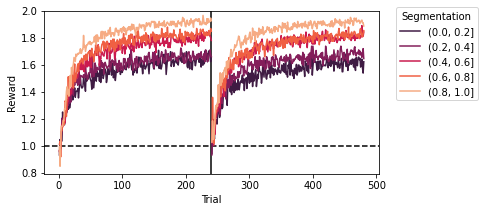

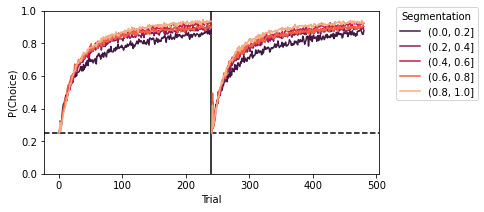

In [13]:
plot_training_curve(
    ff_training_df,
    'reward',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation'
)

plot_training_curve(
    ff_training_df,
    'p',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation'
)

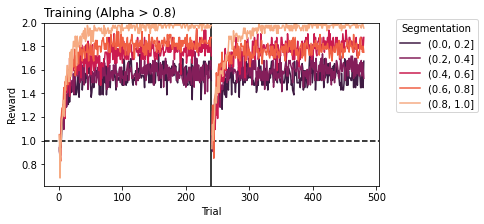

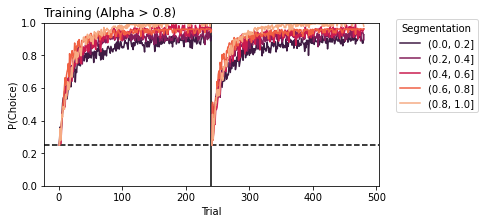

In [14]:
idx = ff_training_df['alpha'] > .8
plot_training_curve(
    ff_training_df.loc[idx],
    'reward',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation',
    title = 'Training (Alpha > 0.8)'
)

plot_training_curve(
    ff_training_df.loc[idx],
    'p',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation',
    title = 'Training (Alpha > 0.8)'
)

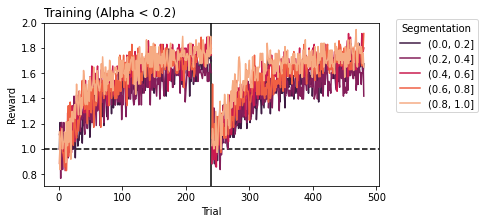

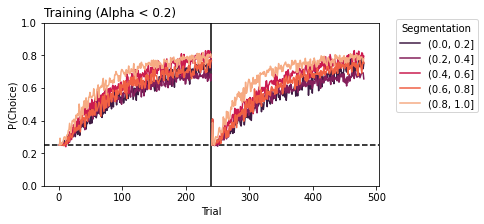

In [15]:
idx = ff_training_df['alpha'] < .2
plot_training_curve(
    ff_training_df.loc[idx],
    'reward',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation',
    title = 'Training (Alpha < 0.2)'
)

plot_training_curve(
    ff_training_df.loc[idx],
    'p',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation',
    title = 'Training (Alpha < 0.2)'
)

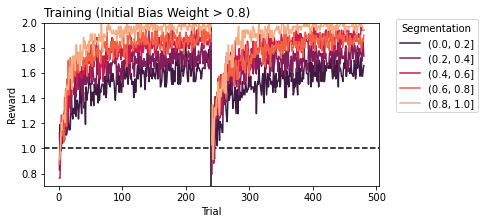

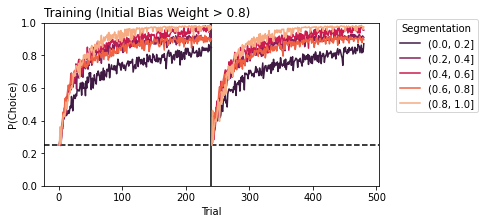

In [17]:
idx = ff_training_df['initial_bias_weight'] > .8
plot_training_curve(
    ff_training_df.loc[idx],
    'reward',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation',
    title = 'Training (Initial Bias Weight > 0.8)'
)

plot_training_curve(
    ff_training_df.loc[idx],
    'p',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation',
    title = 'Training (Initial Bias Weight > 0.8)'
)

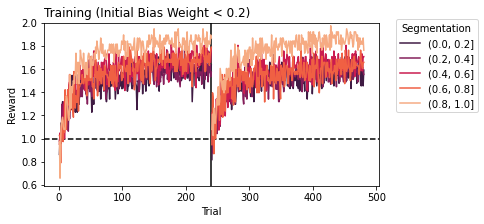

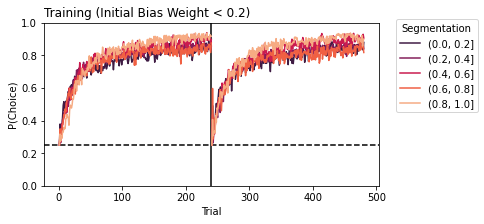

In [20]:
idx = ff_training_df['initial_bias_weight'] < .2
plot_training_curve(
    ff_training_df.loc[idx],
    'reward',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation',
    title = 'Training (Initial Bias Weight < 0.2)'
)

plot_training_curve(
    ff_training_df.loc[idx],
    'p',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation',
    title = 'Training (Initial Bias Weight < 0.2)'
)

In [113]:
if plot_alpha_decay:
    
    idx = ff_training_df['alpha_decay'] > .8
    plot_training_curve(
        ff_training_df.loc[idx],
        'reward',
        'segmentation_bin',
        palette = 'rocket',
        legend_title = 'Segmentation',
        title = 'Training (Alpha Decay > 0.8)'
    )

    idx = ff_training_df['alpha_decay'] < .2
    plot_training_curve(
        ff_training_df.loc[idx],
        'reward',
        'segmentation_bin',
        palette = 'rocket',
        legend_title = 'Segmentation',
        title = 'Training (Alpha Decay < 0.2)'
    )

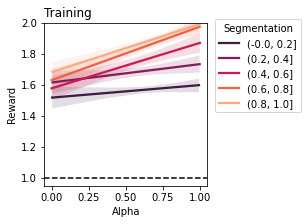

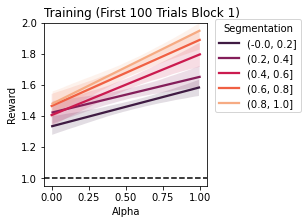

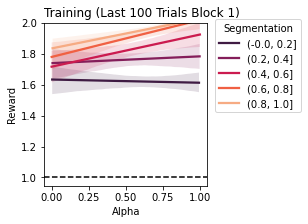

In [114]:
plot_param_interaction(
        ff_training_df,
        'alpha',
        'segmentation_bin',
        'reward',
        title = 'Training',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'Reward',
        palette = 'rocket'
)

plot_param_interaction(
        ff_training_df.loc[ff_training_df['trial'] < 100],
        'alpha',
        'segmentation_bin',
        'reward',
        title = 'Training (First 100 Trials Block 1)',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'Reward',
        palette = 'rocket'
)

idx = (
    (ff_training_df['trial'] > (n_training_trials/2 - 100)) &
    (ff_training_df['block'] == 1)
)
plot_param_interaction(
        ff_training_df.loc[idx],
        'alpha',
        'segmentation_bin',
        'reward',
        title = 'Training (Last 100 Trials Block 1)',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'Reward',
        palette = 'rocket'
)

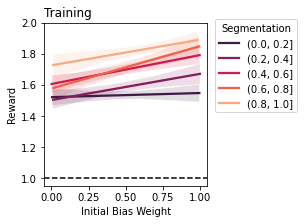

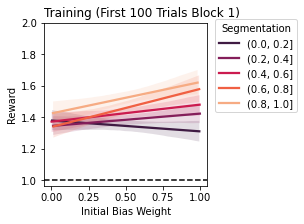

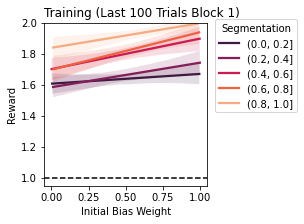

In [22]:
plot_param_interaction(
        ff_training_df,
        'initial_bias_weight',
        'segmentation_bin',
        'reward',
        title = 'Training',
        legend_title = 'Segmentation',
        xlabel = 'Initial Bias Weight',
        ylabel = 'Reward',
        palette = 'rocket'
)

plot_param_interaction(
        ff_training_df.loc[ff_training_df['trial'] < 50],
        'initial_bias_weight',
        'segmentation_bin',
        'reward',
        title = 'Training (First 50 Trials Block 1)',
        legend_title = 'Segmentation',
        xlabel = 'Initial Bias Weight',
        ylabel = 'Reward',
        palette = 'rocket'
)

idx = (
    (ff_training_df['trial'] > (n_training_trials/2 - 50)) &
    (ff_training_df['block'] == 1)
)
plot_param_interaction(
        ff_training_df.loc[idx],
        'initial_bias_weight',
        'segmentation_bin',
        'reward',
        title = 'Training (Last 50 Trials Block 1)',
        legend_title = 'Segmentation',
        xlabel = 'Initial Bias Weight',
        ylabel = 'Reward',
        palette = 'rocket'
)

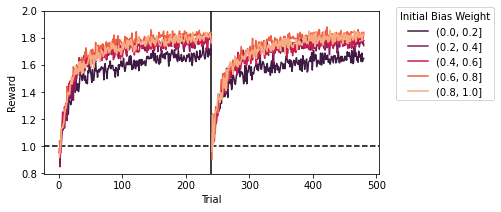

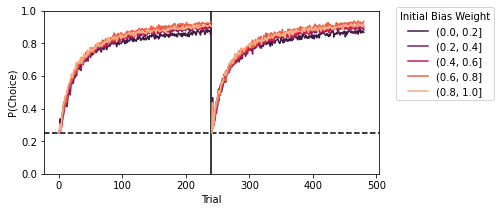

In [16]:
plot_training_curve(
    ff_training_df,
    'reward',
    'initial_bias_weight_bin',
    palette = 'rocket',
    legend_title = 'Initial Bias Weight'
)

plot_training_curve(
    ff_training_df,
    'p',
    'initial_bias_weight_bin',
    palette = 'rocket',
    legend_title = 'Initial Bias Weight'
)

### Transition Influence

In [59]:
def plot_transition_influence_by_param(
    data,
    x,
    x_label = None,
    palette = {
        'incidental': None,
        'true': None
    },
    title = None,
    fname = False
):
    
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.axhline(0, color='black', linestyle='--', zorder=0)

    # Plot true-transition influence
    idx = data['transition'] == 'true'
    sns.regplot(
        data = data.loc[idx],
        x = x,
        y = 'coef',
        scatter_kws = {'s': 1},
        color = palette['true'],
        label = 'True',
        ax = ax
    )

    # Plot incidental transition influence
    idx = data['transition'] == 'incidental'
    sns.regplot(
        data = data.loc[idx],
        x = x,
        y = 'coef',
        scatter_kws = {'s': 1},
        color = palette['incidental'],
        label = 'Incidental',
        ax = ax
    )
    ax.legend(markerscale=4)
    ax.set_ylabel('Transition Influence')
    ax.set_xlabel(x_label)
    ax.set_title(title, loc='left')
    fig.tight_layout()
    if fname:
        fig.savefig(fname)

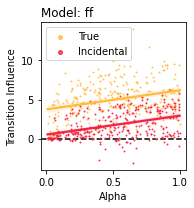

In [64]:
# ff transition influence by alpha
idx = trans_influence_df['model_label'] == 'ff'
plot_df = trans_influence_df.loc[idx, [
    'id',
    'alpha',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'alpha',
    'transition'
])
plot_df = plot_df.mean().reset_index()

# Plot
plot_transition_influence_by_param(
    plot_df,
    'alpha',
    x_label = 'Alpha',
    palette = TRANSITION_INFLUENCE_COLORS,
    title = 'Model: ff',
)

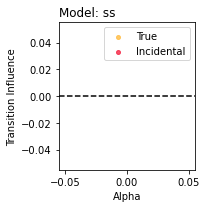

In [65]:
# ss transition influence by alpha
idx = trans_influence_df['model_label'] == 'ss'
plot_df = trans_influence_df.loc[idx, [
    'id',
    'alpha',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'alpha',
    'transition'
])
plot_df = plot_df.mean().reset_index()

# Plot
plot_transition_influence_by_param(
    plot_df,
    'alpha',
    x_label = 'Alpha',
    palette = TRANSITION_INFLUENCE_COLORS,
    title = 'Model: ss',
)

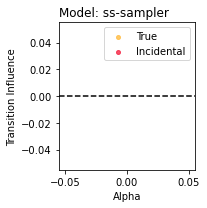

In [66]:
# ss-sampler transition influence by alpha
idx = trans_influence_df['model_label'] == 'ss-sampler'
plot_df = trans_influence_df.loc[idx, [
    'id',
    'alpha',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'alpha',
    'transition'
])
plot_df = plot_df.mean().reset_index()

# Plot
plot_transition_influence_by_param(
    plot_df,
    'alpha',
    x_label = 'Alpha',
    palette = TRANSITION_INFLUENCE_COLORS,
    title = 'Model: ss-sampler',
)

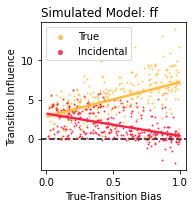

In [60]:
# ff transition influence by segmentation
idx = trans_influence_df['model_label'] == 'ff'
plot_df = trans_influence_df.loc[idx, [
    'id',
    'segmentation',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'segmentation',
    'transition'
])
plot_df = plot_df.mean().reset_index()

# Plot
plot_transition_influence_by_param(
    plot_df,
    'segmentation',
    x_label = 'True-Transition Bias',
    palette = TRANSITION_INFLUENCE_COLORS,
    title = 'Simulated Model: ff',
    fname = f'{FIG_PATH}/transition_influence_by_segmentation.pdf'
)

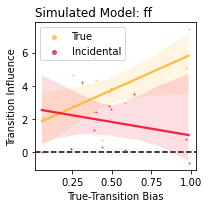

In [68]:
# ff transition influence by segmentation
idx = (
    (trans_influence_df['model_label'] == 'ff') &
    (trans_influence_df['initial_bias_weight'] < .05)
)
plot_df = trans_influence_df.loc[idx, [
    'id',
    'segmentation',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'segmentation',
    'transition'
])
plot_df = plot_df.mean().reset_index()

# Plot
plot_transition_influence_by_param(
    plot_df,
    'segmentation',
    x_label = 'True-Transition Bias',
    palette = TRANSITION_INFLUENCE_COLORS,
    title = 'Simulated Model: ff',
    fname = f'{FIG_PATH}/transition_influence_by_segmentation.pdf'
)

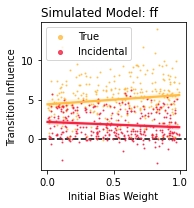

In [61]:
# ff transition influence by initial bias weight
idx = trans_influence_df['model_label'] == 'ff'
plot_df = trans_influence_df.loc[idx, [
    'id',
    'initial_bias_weight',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'initial_bias_weight',
    'transition'
])
plot_df = plot_df.mean().reset_index()

# Plot
plot_transition_influence_by_param(
    plot_df,
    'initial_bias_weight',
    x_label = 'Initial Bias Weight',
    palette = TRANSITION_INFLUENCE_COLORS,
    title = 'Simulated Model: ff',
    fname = f'{FIG_PATH}/transition_influence_by_initial_bias_weight.pdf'
)

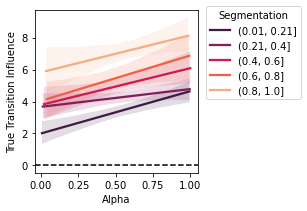

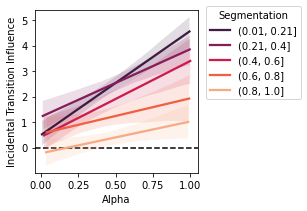

In [62]:
idx = trans_influence_df['model_label'] == 'ff'
plot_df = trans_influence_df.loc[idx]
plot_df['segmentation_bin'] = bin_params(
        plot_df['segmentation'],
        N_PARAM_BINS
)

idx = plot_df['transition'] == 'true'
plot_param_interaction(
        plot_df.loc[idx],
        'alpha',
        'segmentation_bin',
        'coef',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'True Transition Influence',
        palette = 'rocket'
)

idx = plot_df['transition'] == 'incidental'
plot_param_interaction(
        plot_df.loc[idx],
        'alpha',
        'segmentation_bin',
        'coef',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'Incidental Transition Influence',
        palette = 'rocket'
)

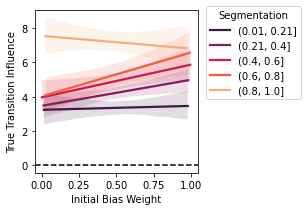

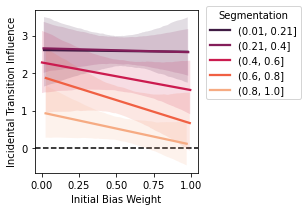

In [63]:
idx = trans_influence_df['model_label'] == 'ff'
plot_df = trans_influence_df.loc[idx]
plot_df['segmentation_bin'] = bin_params(
        plot_df['segmentation'],
        N_PARAM_BINS
)

idx = plot_df['transition'] == 'true'
plot_param_interaction(
        plot_df.loc[idx],
        'initial_bias_weight',
        'segmentation_bin',
        'coef',
        legend_title = 'Segmentation',
        xlabel = 'Initial Bias Weight',
        ylabel = 'True Transition Influence',
        palette = 'rocket'
)

idx = plot_df['transition'] == 'incidental'
plot_param_interaction(
        plot_df.loc[idx],
        'initial_bias_weight',
        'segmentation_bin',
        'coef',
        legend_title = 'Segmentation',
        xlabel = 'Initial Bias Weight',
        ylabel = 'Incidental Transition Influence',
        palette = 'rocket'
)

## Residuals analysis

### Trial-wise residuals by model

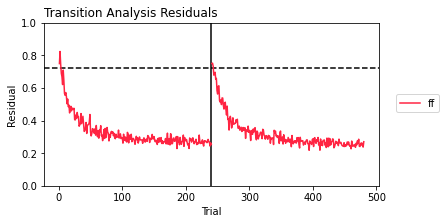

In [75]:
plot_training_curve(
    residuals_df,
    'resid',
    'model_label',
    palette = MODEL_COLORS,
    title = 'Transition Analysis Residuals'
)

### Trial-wise residuals for feature-based model

In [76]:
# Get feature-based model data
idx = residuals_df['model_label'] == 'ff'
ff_residuals_df = residuals_df.loc[idx]
ff_residuals_df = ff_residuals_df.reset_index(drop=True)

# Bin parameters
ff_residuals_df['alpha_bin'] = bin_params(
    ff_residuals_df['alpha'],
    N_PARAM_BINS
)
ff_residuals_df['beta_bin'] = bin_params(
    ff_residuals_df['beta'],
    N_PARAM_BINS,
    method = pd.qcut
)
ff_residuals_df['segmentation_bin'] = bin_params(
    ff_residuals_df['segmentation'],
    N_PARAM_BINS
)

#### Residuals by learning rate

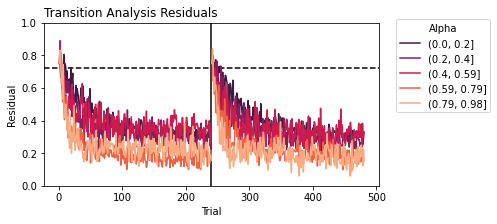

In [77]:
plot_training_curve(
    ff_residuals_df,
    'resid',
    'alpha_bin',
    palette = 'rocket',
    legend_title = 'Alpha',
    title = 'Transition Analysis Residuals'
)

#### Residuals by inverse temperature parameter

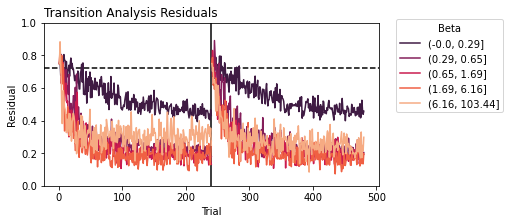

In [78]:
plot_training_curve(
    ff_residuals_df,
    'resid',
    'beta_bin',
    palette = 'rocket',
    legend_title = 'Beta',
    title = 'Transition Analysis Residuals'
)

#### Residuals by segmentation

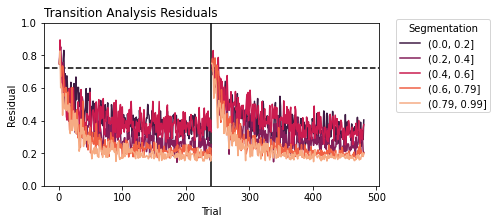

In [79]:
plot_training_curve(
    ff_residuals_df,
    'resid',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation',
    title = 'Transition Analysis Residuals'
)

# Representations

124.96792194529971

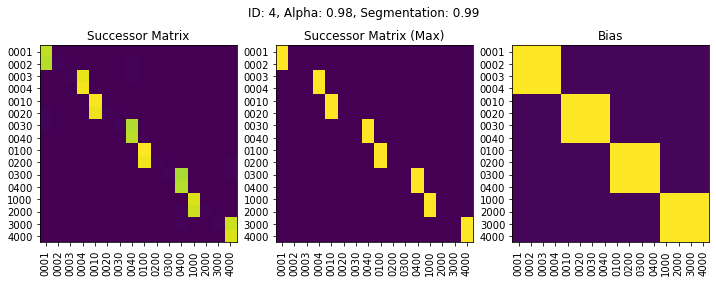

In [44]:
subj = 4
subj_alp = np.round(representations[subj]['agent_info']['alpha'], 2)
subj_seg = np.round(representations[subj]['agent_info']['segmentation'], 2)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(representations[subj]['M'])
axs[0].set_xticks(
    np.arange(len(representations[subj]['col_labels'])),
    labels = representations[subj]['col_labels'],
    size = 10,
    rotation = 90
)
axs[0].set_yticks(
    np.arange(len(representations[subj]['row_labels'])),
    labels = representations[subj]['row_labels']
)
axs[0].set_title('Successor Matrix')

axs[1].imshow(np.array([row == np.max(row) for row in representations[subj]['M']]))
axs[1].set_xticks(
    np.arange(len(representations[subj]['col_labels'])),
    labels = representations[subj]['col_labels'],
    size = 10,
    rotation = 90
)
axs[1].set_yticks(
    np.arange(len(representations[subj]['row_labels'])),
    labels = representations[subj]['row_labels']
)
axs[1].set_title('Successor Matrix (Max)')

axs[2].imshow(representations[subj]['bias'], vmin=0, vmax=1)
axs[2].set_xticks(
    np.arange(len(representations[subj]['col_labels'])),
    labels = representations[subj]['col_labels'],
    size = 10,
    rotation = 90
)
axs[2].set_yticks(
    np.arange(len(representations[subj]['row_labels'])),
    labels = representations[subj]['row_labels']
)
axs[2].set_title('Bias')

fig.suptitle(f'ID: {subj}, Alpha: {subj_alp}, Segmentation: {subj_seg}')

np.max(representations[subj]['M'])